In [1]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.inspection import permutation_importance

### Data Loading

In [2]:
filepath = '../../split_year_data'

In [3]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [4]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [5]:
with open('../../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

In [6]:
output_dir = '../../split_year_models'

### Random Forest

In [7]:
train_input_data['W']

NameError: name 'train_input_data' is not defined

In [ ]:
rf_imp_1_mean = []
rf_imp_95_mean = []
rf_imp_85_mean = []

rf_imp_1_std = []
rf_imp_95_std = []
rf_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].map(countries_dict)
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            rf_imp_85_mean.append(feature_permute.importances_mean)
            rf_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            rf_imp_95_mean.append(feature_permute.importances_mean)
            rf_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            rf_imp_1_mean.append(feature_permute.importances_mean)
            rf_imp_1_std.append(feature_permute.importances_std)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

### LightGBM

In [ ]:
lgb_imp_1_mean = []
lgb_imp_95_mean = []
lgb_imp_85_mean = []

lgb_imp_1_std = []
lgb_imp_95_std = []
lgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        val_data = val_input_data[train_input_data.columns].copy()

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)

        train_load = loaded_model.fit(train_input_data, train_label)
        feature_permute = permutation_importance(train_load, val_data, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            lgb_imp_85_mean.append(feature_permute.importances_mean)
            lgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            lgb_imp_95_mean.append(feature_permute.importances_mean)
            lgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            lgb_imp_1_mean.append(feature_permute.importances_mean)
            lgb_imp_1_std.append(feature_permute.importances_std)

### XGBoost

In [ ]:
xgb_imp_1_mean = []
xgb_imp_95_mean = []
xgb_imp_85_mean = []

xgb_imp_1_std = []
xgb_imp_95_std = []
xgb_imp_85_std = []

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")

        val_input_data = validation[fold][0].copy()
        val_input_data['setting'] = val_input_data['setting'].astype("category")
        val_label = validation[fold][1].copy()

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        bp = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        best_params = {'n_estimators' : bp['number_trees'], 'max_depth' : bp['max_tree_depth'], 'booster' : bp['boosting_type'], 'reg_alpha' : bp['l1_norm'], 
            'reg_lambda' : bp['l2_norm'], 'subsample' : bp['subsample'], 'learning_rate' : bp['learning_rate']}

        loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        feature_permute = permutation_importance(train_load, val_relevant_input, val_label, n_repeats=10, random_state=42)

        if thresh == 0:
            xgb_imp_85_mean.append(feature_permute.importances_mean)
            xgb_imp_85_std.append(feature_permute.importances_std)
        if thresh == 1:
            xgb_imp_95_mean.append(feature_permute.importances_mean)
            xgb_imp_95_std.append(feature_permute.importances_std)
        elif thresh == 2:
            xgb_imp_1_mean.append(feature_permute.importances_mean)
            xgb_imp_1_std.append(feature_permute.importances_std)

### Saving

In [ ]:
with open('../../fs_frommodel_models/year/rf_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_mean, f)
with open('../../fs_frommodel_models/year/rf_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_mean, f)
with open('../../fs_frommodel_models/year/rf_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_mean, f)

with open('../../fs_frommodel_models/year/rf_imp_1_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_1_std, f)
with open('../../fs_frommodel_models/year/rf_imp_95_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_95_std, f)
with open('../../fs_frommodel_models/year/rf_imp_85_std.pkl', 'wb') as f:
    pickle.dump(rf_imp_85_std, f)

In [ ]:
with open('../../fs_frommodel_models/year/lgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_mean, f)
with open('../../fs_frommodel_models/year/lgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_mean, f)
with open('../../fs_frommodel_models/year/lgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_mean, f)

with open('../../fs_frommodel_models/year/lgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_1_std, f)
with open('../../fs_frommodel_models/year/lgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_95_std, f)
with open('../../fs_frommodel_models/year/lgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(lgb_imp_85_std, f)

In [ ]:
with open('../../fs_frommodel_models/year/xgb_imp_1_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_mean, f)
with open('../../fs_frommodel_models/year/xgb_imp_95_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_mean, f)
with open('../../fs_frommodel_models/year/xgb_imp_85_mean.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_mean, f)

with open('../../fs_frommodel_models/year/xgb_imp_1_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_1_std, f)
with open('../../fs_frommodel_models/year/xgb_imp_95_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_95_std, f)
with open('../../fs_frommodel_models/year/xgb_imp_85_std.pkl', 'wb') as f:
    pickle.dump(xgb_imp_85_std, f)

### Comparisons

In [ ]:
lgb_avg_1 = np.mean(lgb_imp_1_mean, axis=0)
lgb_std_1 = np.mean(lgb_imp_1_std, axis=0)
lgb_avg_1 = np.mean(lgb_imp_1_mean, axis=0)

names1 = train[0][2 * 2].columns

# Wrap in DataFrame
lgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance LGBM Threshold = None': lgb_avg_1,
    'Std' : lgb_std_1
}).sort_values(by='Avg_Permutation_Importance LGBM Threshold = None', ascending=False)

lgb_1_imp_pos = lgb_avg_1_df[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] - lgb_avg_1_df['Std'] > 0]
lgb_1_imp_pos_big = lgb_1_imp_pos[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]
print(lgb_1_imp_pos_big.shape)
lgb_1_imp_pos_big
#lgb_avg_1_df.plot.bar(x = 'Feature', yerr='Std', figsize=(15, 8))

(42, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_82613/1679935638.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb_1_imp_pos_big = lgb_1_imp_pos[lgb_avg_1_df['Avg_Permutation_Importance LGBM Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance LGBM Threshold = None,Std
641,Vulnerable employment (% of total employment) ...,0.098323,0.007659
137,"Mortality rate, adult, female (per 1,000 femal...",0.046699,0.003307
116,"Stillbirth rate (per 1,000 total births)",0.032139,0.003080
16,"Survival to age 65, female (% of cohort)",0.016910,0.002466
637,"Self-employed, total (% of total employment) (...",0.016329,0.002332
30,"Mortality rate, under-5, male (per 1,000 live ...",0.008527,0.001908
168,"Contraceptive prevalence, any method (% of mar...",0.008334,0.002268
642,Vulnerable employment (% of total employment) ...,0.006334,0.000967
148,People practicing open defecation (% of popula...,0.006057,0.001158
108,"Mortality rate, under-5, female (per 1,000 liv...",0.005858,0.001400


In [ ]:
rf_avg_1 = np.mean(rf_imp_1_mean, axis=0)
rf_std_1 = np.mean(rf_imp_1_std, axis=0)
rf_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance RF Threshold = None': rf_avg_1,
    'Std' : rf_std_1
}).sort_values(by='Avg_Permutation_Importance RF Threshold = None', ascending=False)
rf_1_imp_pos = rf_avg_1_df[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] - rf_avg_1_df['Std'] > 0]
rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]
print(rf_1_imp_pos_big.shape)
rf_1_imp_pos_big

(24, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_82613/1706408803.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rf_1_imp_pos_big = rf_1_imp_pos[rf_avg_1_df['Avg_Permutation_Importance RF Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance RF Threshold = None,Std
641,Vulnerable employment (% of total employment) ...,0.290340,0.014264
139,"Fertility rate, total (births per woman)",0.023139,0.003297
137,"Mortality rate, adult, female (per 1,000 femal...",0.022863,0.002906
16,"Survival to age 65, female (% of cohort)",0.014641,0.002231
148,People practicing open defecation (% of popula...,0.004453,0.000963
72,"Survival to age 65, male (% of cohort)",0.003317,0.000499
30,"Mortality rate, under-5, male (per 1,000 live ...",0.003007,0.001303
637,"Self-employed, total (% of total employment) (...",0.002902,0.001122
93,"Adolescent fertility rate (births per 1,000 wo...",0.002671,0.000478
122,"Mortality rate, infant, male (per 1,000 live b...",0.002191,0.000779


In [ ]:
xgb_avg_1 = np.mean(xgb_imp_1_mean, axis=0)
xgb_std_1 = np.mean(xgb_imp_1_std, axis=0)
xgb_avg_1_df = pd.DataFrame({
    'Feature': names1,
    'Avg_Permutation_Importance xgb Threshold = None': xgb_avg_1,
    'Std' : xgb_std_1
}).sort_values(by='Avg_Permutation_Importance xgb Threshold = None', ascending=False)
xgb_1_imp_pos = xgb_avg_1_df[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] - xgb_avg_1_df['Std'] > 0]
xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]
print(xgb_1_imp_pos_big.shape)
xgb_1_imp_pos_big

(1, 3)


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_82613/2781861880.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xgb_1_imp_pos_big = xgb_1_imp_pos[xgb_avg_1_df['Avg_Permutation_Importance xgb Threshold = None'] > 0.001]


,Feature,Avg_Permutation_Importance xgb Threshold = None,Std
2,setting,0.005371,0.004474


In [ ]:
rf_lgb_1_intersection = set(lgb_1_imp_pos_big['Feature']) & set(rf_1_imp_pos_big['Feature'])
len(rf_lgb_1_intersection)

17

In [ ]:
rf_only = []
for feature_name in rf_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        rf_only.append(feature_name)

rf_only

['Mortality rate, infant, male (per 1,000 live births)',
 'Condom use at last high-risk sex, adult female (% ages 15-49)',
 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
 'Number of under-five deaths, male',
 "Women's share of population ages 15+ living with HIV (%)",
 'Mortality rate, adult, male (per 1,000 male adults)',
 'Number of infant deaths, female']

In [ ]:
lgb_only = []
for feature_name in lgb_1_imp_pos_big['Feature']:
    if feature_name not in rf_lgb_1_intersection:
        lgb_only.append(feature_name)

lgb_only

['Contraceptive prevalence, any method (% of married women ages 15-49)',
 'Vulnerable employment (% of total employment) (modeled ILO estimate) male',
 'Mortality rate, under-5, female (per 1,000 live births)',
 'setting',
 'Births attended by skilled health staff (% of total)',
 'Mortality caused by road traffic injury, female (per 100,000 female population)',
 'Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)',
 'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate) female',
 'Demand for family planning satisfied by any methods (% of married women with demand for family planning)',
 'Employment in industry (% of total employment) (modeled ILO estimate) male',
 'Prevalence of HIV, female (% ages 15-24)',
 'Employment in agriculture (% of total employment) (modeled ILO estimate) male',
 'Incidence of HIV, ages 15-24 (per 1,000 uninfected population ages 15-24)',
 'Self-employed, total (% of total employment)

### Visualisations

In [ ]:
lgb_to_plot = lgb_1_imp_pos_big[lgb_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]
rf_to_plot = rf_1_imp_pos_big[rf_1_imp_pos_big['Feature'].isin(rf_lgb_1_intersection)]

lgb_to_plot.columns = ['Feature', 'LightGBM', 'Std LightGBM']
rf_to_plot.columns = ['Feature', 'RF', 'Std RF']

data_to_plot = lgb_to_plot.merge(rf_to_plot, on='Feature')
data_to_plot

,Feature,LightGBM,Std LightGBM,RF,Std RF
0,Vulnerable employment (% of total employment) ...,0.098323,0.007659,0.290340,0.014264
1,"Mortality rate, adult, female (per 1,000 femal...",0.046699,0.003307,0.022863,0.002906
2,"Stillbirth rate (per 1,000 total births)",0.032139,0.003080,0.001923,0.000767
3,"Survival to age 65, female (% of cohort)",0.016910,0.002466,0.014641,0.002231
4,"Self-employed, total (% of total employment) (...",0.016329,0.002332,0.002902,0.001122
5,"Mortality rate, under-5, male (per 1,000 live ...",0.008527,0.001908,0.003007,0.001303
6,People practicing open defecation (% of popula...,0.006057,0.001158,0.004453,0.000963
7,"Fertility rate, total (births per woman)",0.004862,0.002248,0.023139,0.003297
8,Wage and salaried workers (% of total employme...,0.004617,0.000764,0.002181,0.001147
9,Employment in agriculture (% of total employme...,0.004229,0.000581,0.001135,0.000437


Text(0.5, 1.0, 'Feature Importances with Error Bars (LightGBM vs RF)')

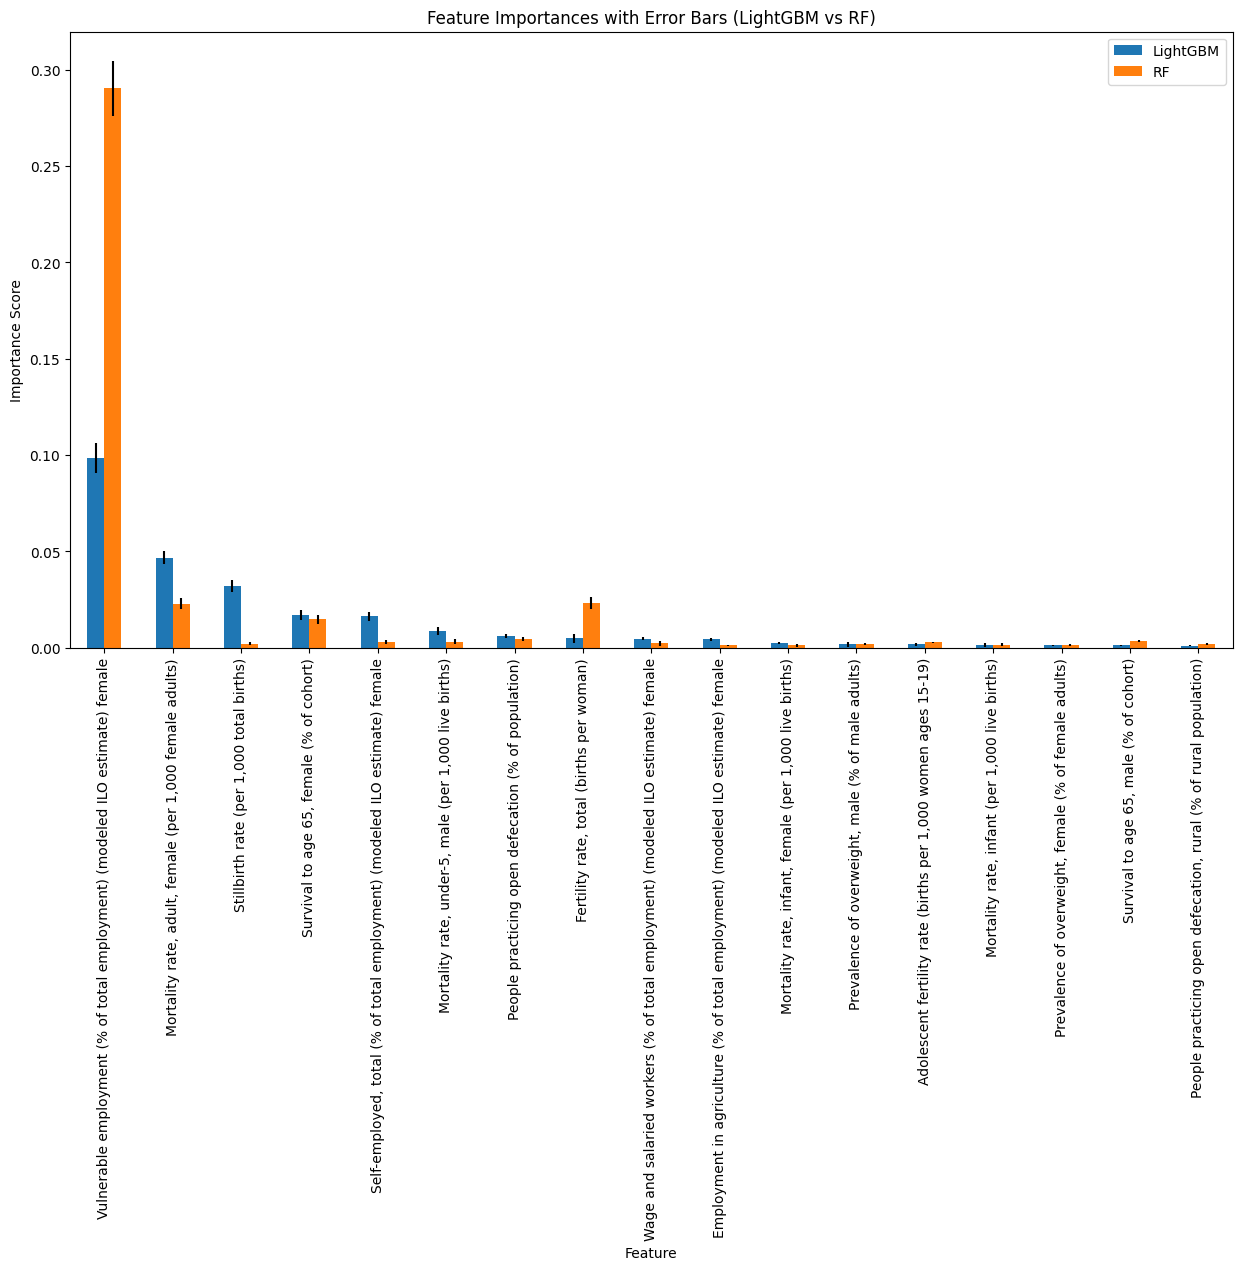

In [ ]:
data_to_plot.index = data_to_plot['Feature']
data_to_plot[['LightGBM', 'RF']].plot.bar(figsize=(15, 8), yerr=data_to_plot[['Std LightGBM', 'Std RF']].to_numpy().T)
plt.ylabel("Importance Score")
plt.title("Feature Importances with Error Bars (LightGBM vs RF)")